# Movie Recommendation with Content-Based and Collaborative Filtering
“*What movie should I watch this evening?*” 

From Netflix to Disney+, the need to build robust movie recommendation systems is extremely important given the huge demand for personalized content of modern consumers.

An example of recommendation system is such as this:
* User A watches **Game of Thrones** and **Breaking Bad**.
* User B does search on **Game of Thrones**, then the system suggests **Breaking Bad** from data collected about user A.

Recommendation systems are used not only for movies, but on multiple other products and services like Amazon (Books, Items), Pandora/Spotify (Music), Google (News, Search), YouTube (Videos) etc.

Two most ubiquitous types of personalized recommendation systems are **Content-Based** and **Collaborative Filtering**. Collaborative filtering produces recommendations based on the knowledge of users’ attitude to items, that is it uses the “wisdom of the crowd” to recommend items. In contrast, content-based recommendation systems focus on the attributes of the items and give you recommendations based on the similarity between them.

In this notebook, we will attempt at implementing these two systems to recommend movies and evaluate them to see which one performs better.

After reading this notebook you will know:

* About the MovieLens dataset problem for recommender system.
* How to load and process the data.
* How to do exploratory data analysis.
* The 2 different types of recommendation engines.
* How to develop a content-based recommendation model based on movie genres.
* How to develop a collaborative filtering model based on user ratings.
* Alternative approach to improve existing models.

Let’s get started.

## The MovieLens Dataset
One of the most common datasets that is available on the internet for building a Recommender System is the [MovieLens DataSet](https://grouplens.org/datasets/movielens/). This version of the dataset that I'm working with ([1M](https://grouplens.org/datasets/movielens/1m/)) contains 1,000,209 anonymous ratings of approximately 3,900 movies made by 6,040 MovieLens users who joined MovieLens in 2000.

The data was collected by GroupLens researchers over various periods of time, depending on the size of the set. This 1M version was released on February 2003. Users were selected at random for inclusion. All users selected had rated at least 20 movies.

## Data Preparation
Let's load this data into Python. I will load the dataset with Pandas onto Dataframes **ratings**, **users**, and **movies**. Before that, I'll also pass in column names for each CSV and read them using pandas.

In [1]:
import pandas as pd
from IPython.display import display
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt

# Reading ratings file
# Ignore the timestamp column
ratings = pd.read_csv('ratings.csv', sep='\t', encoding='latin-1', usecols=['user_id', 'movie_id', 'rating', 'timestamp'])

# Reading users file
users = pd.read_csv('users.csv', sep='\t', encoding='latin-1', usecols=['user_id', 'gender', 'zipcode', 'age_desc', 'occ_desc', 'occupation'])

# Reading movies file
movies = pd.read_csv('movies.csv', sep='\t', encoding='latin-1', usecols=['movie_id', 'title', 'genres'])

Now lets take a peak into the content of each file to understand them better.

### Ratings Dataset

In [2]:
# Check the top 5 rows
ratings.head()

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [3]:
# Check the file info
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype
---  ------     --------------    -----
 0   user_id    1000209 non-null  int64
 1   movie_id   1000209 non-null  int64
 2   rating     1000209 non-null  int64
 3   timestamp  1000209 non-null  int64
dtypes: int64(4)
memory usage: 30.5 MB


This confirms that there are 1M ratings for different user and movie combinations.

### Users Dataset

In [4]:
# Check the top 5 rows
users.head()

,user_id,gender,occupation,zipcode,age_desc,occ_desc
0,1,F,10,48067,Under 18,K-12 student
1,2,M,16,70072,56+,self-employed
2,3,M,15,55117,25-34,scientist
3,4,M,7,02460,45-49,executive/managerial
4,5,M,20,55455,25-34,writer


In [5]:
# Check the file info
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     6040 non-null   int64 
 1   gender      6040 non-null   object
 2   occupation  6040 non-null   int64 
 3   zipcode     6040 non-null   object
 4   age_desc    6040 non-null   object
 5   occ_desc    6040 non-null   object
dtypes: int64(2), object(4)
memory usage: 283.2+ KB


This confirms that there are 6040 users and we have 5 features for each (unique user ID, gender, age, occupation and the zip code they are living in).

### Movies Dataset

In [6]:
# Check the top 5 rows
movies.head()

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [7]:
# Check the file info
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   movie_id  3883 non-null   int64 
 1   title     3883 non-null   object
 2   genres    3883 non-null   object
dtypes: int64(1), object(2)
memory usage: 91.1+ KB


This dataset contains attributes of the 3883 movies. There are 3 columns including the movie ID, their titles, and their genres. Genres are pipe-separated and are selected from 18 genres (Action, Adventure, Animation, Children's, Comedy, Crime, Documentary, Drama, Fantasy, Film-Noir, Horror, Musical, Mystery, Romance, Sci-Fi, Thriller, War, Western).

# Data Exploration

### Ratings
Let's examine the **rating** further. Let's take a look at its summary statistics and distribution.

In [8]:
# Get summary statistics of rating
ratings['rating'].describe()

count    1.000209e+06
mean     3.581564e+00
std      1.117102e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

C:\Users\v13260\AppData\Roaming\Python\Python37\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='rating', ylabel='Density'>

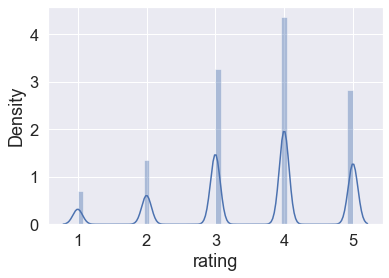

In [9]:
# Import seaborn library
import seaborn as sns
sns.set_style('whitegrid')
sns.set(font_scale=1.5)
%matplotlib inline

# Display distribution of rating
sns.distplot(ratings['rating'].fillna(ratings['rating'].median()))

It appears that users are quite generous in their ratings. The mean rating is 3.58 on a scale of 5. Half the movies have a rating of 4 and 5. I personally think that a 5-level rating skill wasn’t a good indicator as people could have different rating styles (i.e. person A could always use 4 for an average movie, whereas person B only gives 4 out for their favorites). Each user rated at least 20 movies, so I doubt the distribution could be caused just by chance variance in the quality of movies.

Let's also take a look at a subset of 20 movies with the highest rating.

In [10]:
# Join all 3 files into one dataframe
dataset = pd.merge(pd.merge(movies, ratings),users)
# Display 20 movies with highest ratings
dataset[['title','genres','rating']].sort_values('rating', ascending=False).head(20)

,title,genres,rating
0,Toy Story (1995),Animation|Children's|Comedy,5
489283,American Beauty (1999),Comedy|Drama,5
489259,Election (1999),Comedy,5
489257,"Matrix, The (1999)",Action|Sci-Fi|Thriller,5
489256,Dead Ringers (1988),Drama|Thriller,5
489237,Rushmore (1998),Comedy,5
489236,"Simple Plan, A (1998)",Crime|Thriller,5
489226,Hands on a Hard Body (1996),Documentary,5
489224,Pleasantville (1998),Comedy,5
489212,Say Anything... (1989),Comedy|Drama|Romance,5


### Genres
The genres variable will surely be important while building the recommendation engines since it describes the content of the film (i.e. Animation, Horror, Sci-Fi). A basic assumption is that films in the same genre should have similar contents. I'll attempt to see exactly which genres are the most popular.

In [11]:
# Make a census of the genre keywords
genre_labels = set()
for s in movies['genres'].str.split('|').values:
    genre_labels = genre_labels.union(set(s))

# Function that counts the number of times each of the genre keywords appear
def count_word(dataset, ref_col, census):
    keyword_count = dict()
    for s in census: 
        keyword_count[s] = 0
    for census_keywords in dataset[ref_col].str.split('|'):        
        if type(census_keywords) == float and pd.isnull(census_keywords): 
            continue        
        for s in [s for s in census_keywords if s in census]: 
            if pd.notnull(s): 
                keyword_count[s] += 1
    #______________________________________________________________________
    # convert the dictionary in a list to sort the keywords by frequency
    keyword_occurences = []
    for k,v in keyword_count.items():
        keyword_occurences.append([k,v])
    keyword_occurences.sort(key = lambda x:x[1], reverse = True)
    return keyword_occurences, keyword_count

# Calling this function gives access to a list of genre keywords which are sorted by decreasing frequency
keyword_occurences, dum = count_word(movies, 'genres', genre_labels)
keyword_occurences[:5]

[['Drama', 1603],
 ['Comedy', 1200],
 ['Action', 503],
 ['Thriller', 492],
 ['Romance', 471]]

### Years of the movies

In [12]:
movies['year'] = movies['title'].str[-5:-1].astype(int)

In [13]:
movies['year']

0       1995
1       1995
2       1995
3       1995
4       1995
        ... 
3878    2000
3879    2000
3880    2000
3881    2000
3882    2000
Name: year, Length: 3883, dtype: int32

<AxesSubplot:xlabel='year'>

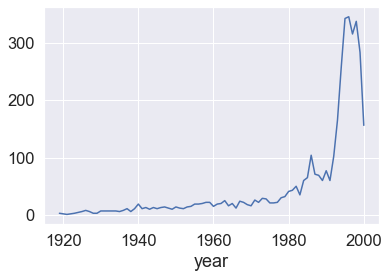

In [14]:
movies.groupby('year').count()['movie_id'].plot()

In [15]:
# sanity check no impossible value here
movies['year'].describe()

count    3883.000000
mean     1986.066959
std        16.895690
min      1919.000000
25%      1982.000000
50%      1994.000000
75%      1997.000000
max      2000.000000
Name: year, dtype: float64

In [16]:
# label encoder
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
movies['year_encode'] = le.fit_transform(movies['year'])

## Types of Recommendation Engines

### 1. Content-Based
The Content-Based Recommender relies on the similarity of the items being recommended. The basic idea is that if you like an item, then you will also like a “similar” item. It generally works well when it's easy to determine the context/properties of each item.

A content based recommender works with data that the user provides, either explicitly movie ratings for the MovieLens dataset. Based on that data, a user profile is generated, which is then used to make suggestions to the user. As the user provides more inputs or takes actions on the recommendations, the engine becomes more and more accurate.

### 2. Collaborative Filtering
The Collaborative Filtering Recommender is entirely based on the past behavior and not on the context. More specifically, it is based on the similarity in preferences, tastes and choices of two users. It analyses how similar the tastes of one user is to another and makes recommendations on the basis of that. 

For instance, if user A likes movies 1, 2, 3 and user B likes movies 2,3,4, then they have similar interests and A should like movie 4 and B should like movie 1. This makes it one of the most commonly used algorithm as it is not dependent on any additional information.

In general, collaborative filtering is the workhorse of recommender engines. The algorithm has a very interesting property of being able to do feature learning on its own, which means that it can start to learn for itself what features to use. It can be divided into **Memory-Based Collaborative Filtering** and **Model-Based Collaborative filtering**.


## Content-Based Recommendation Model
A Content-Based Recommendation Engine that computes similarity between movies based on movie genres. It will suggest movies that are most similar to a particular movie based on its genre. To do so, we will make use of the file **movies.csv**.

### Item-based content-based RecSys

In [17]:
# Break up the big genre string into a string array
movies['genres'] = movies['genres'].str.split('|')

In [18]:
# get the combinations of all genres for each movie
from itertools import combinations

def powerSet(x):
    out = []
    for i in range(len(x) + 1):
        out = out + list(combinations(x, i))
    return out[1:]

movies['genres_comb'] = movies['genres'].apply(lambda x: powerSet(x))
movies['genres_comb']

0       [(Animation,), (Children's,), (Comedy,), (Anim...
1       [(Adventure,), (Children's,), (Fantasy,), (Adv...
2              [(Comedy,), (Romance,), (Comedy, Romance)]
3                  [(Comedy,), (Drama,), (Comedy, Drama)]
4                                             [(Comedy,)]
                              ...                        
3878                                          [(Comedy,)]
3879                                           [(Drama,)]
3880                                           [(Drama,)]
3881                                           [(Drama,)]
3882           [(Drama,), (Thriller,), (Drama, Thriller)]
Name: genres_comb, Length: 3883, dtype: object

In [19]:
# convert to multiple column using MultiLabelBinarizer
from sklearn.preprocessing import MultiLabelBinarizer
multilabel = MultiLabelBinarizer()
movies_matrix = multilabel.fit_transform(movies['genres_comb'])

In [20]:
# append with the encoded year column
movies_matrix = np.append(movies_matrix,np.array(movies['year_encode']).reshape(len(movies),1), axis=1)
movies_matrix.shape

(3883, 494)

In [21]:
# calculate cosine similarity
def cosine_similarity(matrix):
    d = matrix @ matrix.T
    norm = (matrix * matrix).sum(1, keepdims=True) ** .5
    return d / norm / norm.T

cosine_sim = cosine_similarity(movies_matrix)
cosine_sim.shape

(3883, 3883)

I now have a pairwise cosine similarity matrix for all the movies in the dataset. The next step is to write a function that returns the 20 most similar movies based on the cosine similarity score.

In [22]:
# Build a 1-dimensional array with movie titles
indices = pd.Series(movies.index, index=movies['title'])

# Function that get movie recommendations based on the cosine similarity score of movie genres
def genre_recommendations(title):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:21]
    movie_indices = [i[0] for i in sim_scores]
    return movies.iloc[movie_indices]

Let's try and get the top recommendations for a few movies and see how good the recommendations are.

In [23]:
genre_recommendations('Singin\' in the Rain (1952)').head(20)

,movie_id,title,genres,year,year_encode,genres_comb
888,900,"American in Paris, An (1951)","[Musical, Romance]",1951,31,"[(Musical,), (Romance,), (Musical, Romance)]"
1878,1947,West Side Story (1961),"[Musical, Romance]",1961,41,"[(Musical,), (Romance,), (Musical, Romance)]"
902,914,My Fair Lady (1964),"[Musical, Romance]",1964,44,"[(Musical,), (Romance,), (Musical, Romance)]"
1072,1088,Dirty Dancing (1987),"[Musical, Romance]",1987,67,"[(Musical,), (Romance,), (Musical, Romance)]"
1043,1057,Everyone Says I Love You (1996),"[Comedy, Musical, Romance]",1996,76,"[(Comedy,), (Musical,), (Romance,), (Comedy, M..."
1360,1381,Grease 2 (1982),"[Comedy, Musical, Romance]",1982,62,"[(Comedy,), (Musical,), (Romance,), (Comedy, M..."
1359,1380,Grease (1978),"[Comedy, Musical, Romance]",1978,58,"[(Comedy,), (Musical,), (Romance,), (Comedy, M..."
3543,3612,"Slipper and the Rose, The (1976)","[Adventure, Musical, Romance]",1976,56,"[(Adventure,), (Musical,), (Romance,), (Advent..."
3246,3315,Happy Go Lovely (1951),[Musical],1951,31,"[(Musical,)]"
3606,3675,White Christmas (1954),[Musical],1954,34,"[(Musical,)]"


In [24]:
genre_recommendations('Saving Private Ryan (1998)').head(20)

,movie_id,title,genres,year,year_encode,genres_comb
2358,2427,"Thin Red Line, The (1998)","[Action, Drama, War]",1998,78,"[(Action,), (Drama,), (War,), (Action, Drama),..."
1545,1586,G.I. Jane (1997),"[Action, Drama, War]",1997,77,"[(Action,), (Drama,), (War,), (Action, Drama),..."
3684,3753,"Patriot, The (2000)","[Action, Drama, War]",2000,80,"[(Action,), (Drama,), (War,), (Action, Drama),..."
108,110,Braveheart (1995),"[Action, Drama, War]",1995,75,"[(Action,), (Drama,), (War,), (Action, Drama),..."
461,465,Heaven & Earth (1993),"[Action, Drama, War]",1993,73,"[(Action,), (Drama,), (War,), (Action, Drama),..."
1222,1242,Glory (1989),"[Action, Drama, War]",1989,69,"[(Action,), (Drama,), (War,), (Action, Drama),..."
1204,1222,Full Metal Jacket (1987),"[Action, Drama, War]",1987,67,"[(Action,), (Drama,), (War,), (Action, Drama),..."
1214,1233,"Boat, The (Das Boot) (1981)","[Action, Drama, War]",1981,61,"[(Action,), (Drama,), (War,), (Action, Drama),..."
1689,1740,Men of Means (1998),"[Action, Drama]",1998,78,"[(Action,), (Drama,), (Action, Drama)]"
1736,1796,In God's Hands (1998),"[Action, Drama]",1998,78,"[(Action,), (Drama,), (Action, Drama)]"


In [25]:
genre_recommendations('Toy Story (1995)').head(20)

,movie_id,title,genres,year,year_encode,genres_comb
1050,1064,Aladdin and the King of Thieves (1996),"[Animation, Children's, Comedy]",1996,76,"[(Animation,), (Children's,), (Comedy,), (Anim..."
2285,2354,"Rugrats Movie, The (1998)","[Animation, Children's, Comedy]",1998,78,"[(Animation,), (Children's,), (Comedy,), (Anim..."
2286,2355,"Bug's Life, A (1998)","[Animation, Children's, Comedy]",1998,78,"[(Animation,), (Children's,), (Comedy,), (Anim..."
3045,3114,Toy Story 2 (1999),"[Animation, Children's, Comedy]",1999,79,"[(Animation,), (Children's,), (Comedy,), (Anim..."
2073,2142,"American Tail: Fievel Goes West, An (1991)","[Animation, Children's, Comedy]",1991,71,"[(Animation,), (Children's,), (Comedy,), (Anim..."
3682,3751,Chicken Run (2000),"[Animation, Children's, Comedy]",2000,80,"[(Animation,), (Children's,), (Comedy,), (Anim..."
3685,3754,"Adventures of Rocky and Bullwinkle, The (2000)","[Animation, Children's, Comedy]",2000,80,"[(Animation,), (Children's,), (Comedy,), (Anim..."
2072,2141,"American Tail, An (1986)","[Animation, Children's, Comedy]",1986,66,"[(Animation,), (Children's,), (Comedy,), (Anim..."
12,13,Balto (1995),"[Animation, Children's]",1995,75,"[(Animation,), (Children's,), (Animation, Chil..."
53,54,"Big Green, The (1995)","[Children's, Comedy]",1995,75,"[(Children's,), (Comedy,), (Children's, Comedy)]"


In [26]:
genre_recommendations('Bambi (1942)').head(20)

,movie_id,title,genres,year,year_encode,genres_comb
592,596,Pinocchio (1940),"[Animation, Children's]",1940,20,"[(Animation,), (Children's,), (Animation, Chil..."
2016,2085,101 Dalmatians (1961),"[Animation, Children's]",1961,41,"[(Animation,), (Children's,), (Animation, Chil..."
1012,1025,"Sword in the Stone, The (1963)","[Animation, Children's]",1963,43,"[(Animation,), (Children's,), (Animation, Chil..."
1010,1023,Winnie the Pooh and the Blustery Day (1968),"[Animation, Children's]",1968,48,"[(Animation,), (Children's,), (Animation, Chil..."
612,616,"Aristocats, The (1970)","[Animation, Children's]",1970,50,"[(Animation,), (Children's,), (Animation, Chil..."
2068,2137,Charlotte's Web (1973),"[Animation, Children's]",1973,53,"[(Animation,), (Children's,), (Animation, Chil..."
2965,3034,Robin Hood (1973),"[Animation, Children's]",1973,53,"[(Animation,), (Children's,), (Animation, Chil..."
2021,2090,"Rescuers, The (1977)","[Animation, Children's]",1977,57,"[(Animation,), (Children's,), (Animation, Chil..."
1020,1033,"Fox and the Hound, The (1981)","[Animation, Children's]",1981,61,"[(Animation,), (Children's,), (Animation, Chil..."
2070,2139,"Secret of NIMH, The (1982)","[Animation, Children's]",1982,62,"[(Animation,), (Children's,), (Animation, Chil..."


### User-based content-based RecSys

In [27]:
# encode users features
le = preprocessing.OneHotEncoder(sparse=False)
users_matrix = le.fit_transform(users[['gender', 'zipcode', 'age_desc', 'occupation']])    
users_matrix.shape

(6040, 3469)

In [28]:
# calculate cosine similarity
cosine_sim = cosine_similarity(users_matrix)
cosine_sim = 1 - cosine_sim
cosine_sim.shape

(6040, 6040)

In [29]:
##### Build a 1-dimensional array with user_id
indices = pd.Series(users.index, index=users['user_id'])

# Function that get movie recommendations based on the cosine similarity score of users
def users_recommendations(userid):
    idx = indices[userid]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:21]
    user_indices = [i[0] for i in sim_scores]
    top3_similar_users = users.iloc[user_indices]
    print("Our user's 5* movies:")
    own_top5 = dataset[(dataset['user_id']==userid) & (dataset['rating']==5)]
    display(own_top5)
    print("Top 3 similar users and their 5* movies ")
    for i in user_indices[:3]:
        rec_top5 = dataset[(dataset['user_id']==i) & (dataset['rating']==5)]
        display(rec_top5)

In [30]:
users_recommendations(115)

Our user's 5* movies:


,movie_id,title,genres,user_id,rating,timestamp,gender,occupation,zipcode,age_desc,occ_desc
944899,70,From Dusk Till Dawn (1996),Action|Comedy|Crime|Horror|Thriller,115,5,977501976,M,17,28083,25-34,technician/engineer
944901,480,Jurassic Park (1993),Action|Adventure|Sci-Fi,115,5,977501908,M,17,28083,25-34,technician/engineer
944905,1129,Escape from New York (1981),Action|Adventure|Sci-Fi|Thriller,115,5,977501936,M,17,28083,25-34,technician/engineer
944906,1407,Scream (1996),Horror|Thriller,115,5,977501603,M,17,28083,25-34,technician/engineer
944907,1544,"Lost World: Jurassic Park, The (1997)",Action|Adventure|Sci-Fi|Thriller,115,5,977501986,M,17,28083,25-34,technician/engineer
944911,2011,Back to the Future Part II (1989),Comedy|Sci-Fi,115,5,977501165,M,17,28083,25-34,technician/engineer
944912,2028,Saving Private Ryan (1998),Action|Drama|War,115,5,977501165,M,17,28083,25-34,technician/engineer
944915,2791,Airplane! (1980),Comedy,115,5,977501871,M,17,28083,25-34,technician/engineer
944916,2792,Airplane II: The Sequel (1982),Comedy,115,5,977501965,M,17,28083,25-34,technician/engineer
944917,2858,American Beauty (1999),Comedy|Drama,115,5,977501871,M,17,28083,25-34,technician/engineer


Top 3 similar users and their 5* movies 


,movie_id,title,genres,user_id,rating,timestamp,gender,occupation,zipcode,age_desc,occ_desc
682225,29,"City of Lost Children, The (1995)",Adventure|Sci-Fi,5,5,978245065,M,20,55455,25-34,writer
682232,50,"Usual Suspects, The (1995)",Crime|Thriller,5,5,978244205,M,20,55455,25-34,writer
682274,913,"Maltese Falcon, The (1941)",Film-Noir|Mystery,5,5,978242740,M,20,55455,25-34,writer
682277,994,Big Night (1996),Drama,5,5,978244540,M,20,55455,25-34,writer
682278,1046,Beautiful Thing (1996),Drama|Romance,5,5,978244114,M,20,55455,25-34,writer
682279,1089,Reservoir Dogs (1992),Crime|Thriller,5,5,978244205,M,20,55455,25-34,writer
682284,1175,Delicatessen (1991),Comedy|Sci-Fi,5,5,978244759,M,20,55455,25-34,writer
682286,1192,Paris Is Burning (1990),Documentary,5,5,978244493,M,20,55455,25-34,writer
682287,1213,GoodFellas (1990),Crime|Drama,5,5,978244177,M,20,55455,25-34,writer
682289,1250,"Bridge on the River Kwai, The (1957)",Drama|War,5,5,978241112,M,20,55455,25-34,writer


,movie_id,title,genres,user_id,rating,timestamp,gender,occupation,zipcode,age_desc,occ_desc
263,1,Toy Story (1995),Animation|Children's|Comedy,9,5,978225952,M,17,61614,25-34,technician/engineer
266,47,Seven (Se7en) (1995),Crime|Thriller,9,5,978226093,M,17,61614,25-34,technician/engineer
272,318,"Shawshank Redemption, The (1994)",Drama,9,5,978225883,M,17,61614,25-34,technician/engineer
278,457,"Fugitive, The (1993)",Action|Thriller,9,5,978226006,M,17,61614,25-34,technician/engineer
282,527,Schindler's List (1993),Drama|War,9,5,978225303,M,17,61614,25-34,technician/engineer
283,529,Searching for Bobby Fischer (1993),Drama,9,5,978226564,M,17,61614,25-34,technician/engineer
284,590,Dances with Wolves (1990),Adventure|Drama|Western,9,5,978226434,M,17,61614,25-34,technician/engineer
285,593,"Silence of the Lambs, The (1991)",Drama|Thriller,9,5,978225314,M,17,61614,25-34,technician/engineer
290,778,Trainspotting (1996),Drama,9,5,978226248,M,17,61614,25-34,technician/engineer
316,1584,Contact (1997),Drama|Sci-Fi,9,5,978226233,M,17,61614,25-34,technician/engineer


,movie_id,title,genres,user_id,rating,timestamp,gender,occupation,zipcode,age_desc,occ_desc
682458,110,Braveheart (1995),Action|Drama|War,15,5,978196933,M,7,22903,25-34,executive/managerial
682637,3510,Frequency (2000),Drama|Thriller,15,5,978361393,M,7,22903,25-34,executive/managerial
682641,3578,Gladiator (2000),Action|Drama,15,5,978196546,M,7,22903,25-34,executive/managerial
682647,3753,"Patriot, The (2000)",Action|Drama|War,15,5,978196741,M,7,22903,25-34,executive/managerial


Overall, here are the pros of using content-based recommendation:
* Can recommend to users with unique tastes.
* Can recommend new & unpopular items.
* Can provide explanations for recommended items by listing content-features that caused an item to be recommended (in this case, movie genres)

However, there are some cons of using this approach:
* Finding the appropriate features is hard.
* Does not recommend items outside a user's profile.
* Unable to exploit ratings.

## Collaborative Filtering Recommendation Model
The content based engine suffers from some severe limitations. It is only capable of suggesting movies which are close to a certain movie. That is, it is not capable of capturing tastes and providing recommendations across genres.

Also, the engine that we built is not really personal in that it doesn't capture the personal tastes and biases of a user. Anyone querying our engine for recommendations based on a movie will receive the same recommendations for that movie, regardless of who she/he is.

Therefore, in this section, we will use Memory-Based Collaborative Filtering to make recommendations to users. 

### Theory
There are 2 main types of memory-based collaborative filtering algorithms:
1. **User-based Collaborative Filtering**: Here we find look alike users based on similarity and recommend movies which first user’s look-alike has chosen in past. This algorithm is very effective but takes a lot of time and resources. It requires to compute every user pair information which takes time.
2. **Item-based Collaborative Filtering**: It is quite similar to previous algorithm, but instead of finding user's look-alike, we try finding movie's look-alike. Once we have movie's look-alike matrix, we can easily recommend alike movies to user who have rated any movie from the dataset. 

In [31]:
ratings = ratings.sort_values(by='timestamp').reset_index(drop=True)

In [32]:
ratings['datetime'] = pd.to_datetime(ratings['timestamp'],unit='s')

In [33]:
ratings

,user_id,movie_id,rating,timestamp,datetime
0,6040,858,4,956703932,2000-04-25 23:05:32
1,6040,2384,4,956703954,2000-04-25 23:05:54
2,6040,593,5,956703954,2000-04-25 23:05:54
3,6040,1961,4,956703977,2000-04-25 23:06:17
4,6040,2019,5,956703977,2000-04-25 23:06:17
...,...,...,...,...,...
1000204,4958,2399,1,1046454338,2003-02-28 17:45:38
1000205,4958,1407,5,1046454443,2003-02-28 17:47:23
1000206,4958,3264,4,1046454548,2003-02-28 17:49:08
1000207,4958,2634,3,1046454548,2003-02-28 17:49:08


<AxesSubplot:xlabel='datetime'>

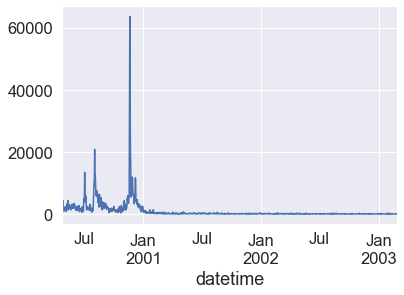

In [34]:
# test amount of rating activity by datetime
# we can use the unusual amount of data in late 2000 => nothing we can do about it
test = ratings.resample('D', on='datetime').count()
test['datetime'].plot()

Use only a random sample of 20,000 ratings (2%) from the 1M ratings.

In [35]:
small_data = ratings.sample(frac=0.02, random_state=0)
# Check the sample info
print(small_data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20004 entries, 324271 to 200452
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   user_id    20004 non-null  int64         
 1   movie_id   20004 non-null  int64         
 2   rating     20004 non-null  int64         
 3   timestamp  20004 non-null  int64         
 4   datetime   20004 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(4)
memory usage: 937.7 KB
None


In [36]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(small_data, test_size=0.2, shuffle=False, random_state=0)

Now I need to create a user-item matrix. Since I have splitted the data into testing and training, I need to create two matrices. The training matrix contains 80% of the ratings and the testing matrix contains 20% of the ratings.

In [37]:
n_users = ratings['user_id'].max()
n_movies = ratings['movie_id'].max()

#Create two user-item matrices, one for training and another for testing
train_data_matrix = np.zeros((n_users, n_movies))
for line in train_data.itertuples():
    train_data_matrix[line[1]-1, line[2]-1] = line[3]

test_data_matrix = np.zeros((n_users, n_movies))
for line in test_data.itertuples():
    test_data_matrix[line[1]-1, line[2]-1] = line[3]

# Check their shape
print(train_data_matrix.shape)
print(test_data_matrix.shape)

(6040, 3952)
(6040, 3952)


Use the **pairwise_distances** function from sklearn to calculate the cosine similarity (correlation). 

In [38]:
from sklearn.metrics.pairwise import pairwise_distances

# User Similarity Matrix
user_correlation = 1 - pairwise_distances(train_data_matrix, metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation[:4, :4])

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


In [39]:
# Item Similarity Matrix
item_correlation = 1 - pairwise_distances(train_data_matrix.T, metric='cosine')
item_correlation[np.isnan(item_correlation)] = 0
print(item_correlation[:4, :4])

[[1.         0.         0.         0.        ]
 [0.         1.         0.08303753 0.        ]
 [0.         0.08303753 1.         0.        ]
 [0.         0.         0.         1.        ]]


With the similarity matrix in hand, I can now predict the ratings that were not included with the data. Using these predictions, I can then compare them with the test data to attempt to validate the quality of our recommender model.

For the user-user CF case, I will look at the similarity between 2 users (A and B, for example) as weights that are multiplied by the ratings of a similar user B (corrected for the average rating of that user). I also need to normalize it so that the ratings stay between 1 and 5 and, as a final step, sum the average ratings for the user that I am trying to predict. The idea here is that some users may tend always to give high or low ratings to all movies. The relative difference in the ratings that these users give is more important than the absolute values. 

In [40]:
# Function to predict ratings
def predict(ratings, similarity, type='user'):
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)
        # Use np.newaxis so that mean_user_rating has same format as ratings
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis])
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
    return pred

### Evaluation

In [41]:
from sklearn.metrics import mean_squared_error

# Function to calculate RMSE
def rmse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return np.sqrt(mean_squared_error(pred, actual))

In [42]:
# Predict ratings on the training data with both similarity score
user_prediction = predict(train_data_matrix, user_correlation, type='user')
item_prediction = predict(train_data_matrix, item_correlation, type='item')

# RMSE on the train data
print('User-based CF RMSE: ' + str(rmse(user_prediction, train_data_matrix)))
print('Item-based CF RMSE: ' + str(rmse(item_prediction, train_data_matrix)))

User-based CF RMSE: 2.6674767852032084
Item-based CF RMSE: 2.87198396465124


In [43]:
# Predict ratings on the training data with both similarity score
user_prediction = predict(test_data_matrix, user_correlation, type='user')
item_prediction = predict(test_data_matrix, item_correlation, type='item')

# RMSE on the train data
print('User-based CF RMSE: ' + str(rmse(user_prediction, test_data_matrix)))
print('Item-based CF RMSE: ' + str(rmse(item_prediction, test_data_matrix)))

User-based CF RMSE: 3.2471153785457876
Item-based CF RMSE: 3.1429775174182146


In [44]:
def recommend_movies(predictions, userID, movies, original_ratings, num_recommendations):
    
    # Get and sort the user's predictions
    user_row_number = userID - 1 # User ID starts at 1, not 0
    sorted_user_predictions = pd.DataFrame(predictions).reset_index(drop=True).iloc[user_row_number]
    
    # Get the user's data and merge in the movie information.
    user_data = original_ratings[original_ratings.user_id == (userID)]
    user_full = (user_data.merge(movies, how = 'left', left_on = 'movie_id', right_on = 'movie_id').
                     sort_values(['rating'], ascending=False)
                 )

    print('User {0} has already rated {1} movies.'.format(userID, user_full.shape[0]))
    print('Recommending highest {0} predicted ratings movies not already rated.'.format(num_recommendations))
    
    # Recommend the highest predicted rating movies that the user hasn't seen yet.
    recommendations = movies[~movies['movie_id'].isin(user_full['movie_id'])]
    recommendations = recommendations.merge(sorted_user_predictions, how = 'left',
               left_on = 'movie_id',
               right_on = sorted_user_predictions.index)
    recommendations = recommendations.rename(columns = {user_row_number: 'Predictions'})
    recommendations = recommendations.sort_values('Predictions', ascending = False)
    recommendations = recommendations.iloc[:num_recommendations, :-1]
                      

    return user_full, recommendations

In [45]:
already_rated, predictions = recommend_movies(user_prediction, 115, movies, ratings, 10)

User 115 has already rated 38 movies.
Recommending highest 10 predicted ratings movies not already rated.


In [46]:
already_rated

,user_id,movie_id,rating,timestamp,datetime,title,genres,year,year_encode,genres_comb
0,115,2028,5,977501165,2000-12-22 16:06:05,Saving Private Ryan (1998),"[Action, Drama, War]",1998,78,"[(Action,), (Drama,), (War,), (Action, Drama),..."
18,115,3751,5,977501884,2000-12-22 16:18:04,Chicken Run (2000),"[Animation, Children's, Comedy]",2000,80,"[(Animation,), (Children's,), (Comedy,), (Anim..."
16,115,2791,5,977501871,2000-12-22 16:17:51,Airplane! (1980),[Comedy],1980,60,"[(Comedy,)]"
15,115,2858,5,977501871,2000-12-22 16:17:51,American Beauty (1999),"[Comedy, Drama]",1999,79,"[(Comedy,), (Drama,), (Comedy, Drama)]"
14,115,3578,5,977501871,2000-12-22 16:17:51,Gladiator (2000),"[Action, Drama]",2000,80,"[(Action,), (Drama,), (Action, Drama)]"
25,115,1129,5,977501936,2000-12-22 16:18:56,Escape from New York (1981),"[Action, Adventure, Sci-Fi, Thriller]",1981,61,"[(Action,), (Adventure,), (Sci-Fi,), (Thriller..."
30,115,70,5,977501976,2000-12-22 16:19:36,From Dusk Till Dawn (1996),"[Action, Comedy, Crime, Horror, Thriller]",1996,76,"[(Action,), (Comedy,), (Crime,), (Horror,), (T..."
10,115,3793,5,977501736,2000-12-22 16:15:36,X-Men (2000),"[Action, Sci-Fi]",2000,80,"[(Action,), (Sci-Fi,), (Action, Sci-Fi)]"
21,115,480,5,977501908,2000-12-22 16:18:28,Jurassic Park (1993),"[Action, Adventure, Sci-Fi]",1993,73,"[(Action,), (Adventure,), (Sci-Fi,), (Action, ..."
8,115,3300,5,977501736,2000-12-22 16:15:36,Pitch Black (2000),"[Action, Sci-Fi]",2000,80,"[(Action,), (Sci-Fi,), (Action, Sci-Fi)]"


In [47]:
predictions

,movie_id,title,genres,year,year_encode,genres_comb
0,1,Toy Story (1995),"[Animation, Children's, Comedy]",1995,75,"[(Animation,), (Children's,), (Comedy,), (Anim..."
2403,2487,"Blood, Guts, Bullets and Octane (1998)","[Action, Comedy]",1998,78,"[(Action,), (Comedy,), (Action, Comedy)]"
2555,2639,Mommie Dearest (1981),[Drama],1981,61,"[(Drama,)]"
2556,2640,Superman (1978),"[Action, Adventure, Sci-Fi]",1978,58,"[(Action,), (Adventure,), (Sci-Fi,), (Action, ..."
2557,2641,Superman II (1980),"[Action, Adventure, Sci-Fi]",1980,60,"[(Action,), (Adventure,), (Sci-Fi,), (Action, ..."
2558,2642,Superman III (1983),"[Action, Adventure, Sci-Fi]",1983,63,"[(Action,), (Adventure,), (Sci-Fi,), (Action, ..."
2559,2643,Superman IV: The Quest for Peace (1987),"[Action, Adventure, Sci-Fi]",1987,67,"[(Action,), (Adventure,), (Sci-Fi,), (Action, ..."
2560,2644,Dracula (1931),[Horror],1931,11,"[(Horror,)]"
2561,2645,Dracula (1958),[Horror],1958,38,"[(Horror,)]"
2562,2646,House of Dracula (1945),[Horror],1945,25,"[(Horror,)]"


In [48]:
predictions

,movie_id,title,genres,year,year_encode,genres_comb
0,1,Toy Story (1995),"[Animation, Children's, Comedy]",1995,75,"[(Animation,), (Children's,), (Comedy,), (Anim..."
2403,2487,"Blood, Guts, Bullets and Octane (1998)","[Action, Comedy]",1998,78,"[(Action,), (Comedy,), (Action, Comedy)]"
2555,2639,Mommie Dearest (1981),[Drama],1981,61,"[(Drama,)]"
2556,2640,Superman (1978),"[Action, Adventure, Sci-Fi]",1978,58,"[(Action,), (Adventure,), (Sci-Fi,), (Action, ..."
2557,2641,Superman II (1980),"[Action, Adventure, Sci-Fi]",1980,60,"[(Action,), (Adventure,), (Sci-Fi,), (Action, ..."
2558,2642,Superman III (1983),"[Action, Adventure, Sci-Fi]",1983,63,"[(Action,), (Adventure,), (Sci-Fi,), (Action, ..."
2559,2643,Superman IV: The Quest for Peace (1987),"[Action, Adventure, Sci-Fi]",1987,67,"[(Action,), (Adventure,), (Sci-Fi,), (Action, ..."
2560,2644,Dracula (1931),[Horror],1931,11,"[(Horror,)]"
2561,2645,Dracula (1958),[Horror],1958,38,"[(Horror,)]"
2562,2646,House of Dracula (1945),[Horror],1945,25,"[(Horror,)]"


Overall, Memory-based Collaborative Filtering is easy to implement and produce reasonable prediction quality. However, there are some drawbacks of this approach:

* It doesn't address the well-known cold-start problem, that is when new user or new item enters the system. 
* It can't deal with sparse data, meaning it's hard to find users that have rated the same items.
* It tends to recommend popular items.

In [49]:
from surprise import SVD, Reader, Dataset, accuracy
from surprise.model_selection import train_test_split

reader = Reader(rating_scale=(1, 5))

# Load the dataset (download it if needed),
data = Dataset.load_from_df(small_data[['user_id', 'movie_id', 'rating']], reader)

# testset = Dataset.load_from_df(test_data[['user_id', 'movie_id', 'rating']], reader)

# sample random trainset and testset
# test set is made of 25% of the ratings.
trainset, testset = train_test_split(data, test_size=.2, random_state=0, shuffle=True)

# We'll use the famous SVD algorithm.
algo = SVD()

# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
predictions = algo.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

RMSE: 1.0156


1.0155944754753117

In [50]:
SVD_predictions = pd.DataFrame(predictions)
SVD_predictions = SVD_predictions.rename(columns={'uid':'user_id', 'iid': 'movie_id', 
                            'r_ui':'actual', 'est':'rating'})

SVD_pred_matrix = np.zeros((n_users, n_movies))
for line in SVD_predictions.itertuples():
    SVD_pred_matrix[line[1]-1, line[2]-1] = line[3]
    
# SVD_predictions = SVD_predictions.pivot_table(index='user_id', 
#                             columns='movie_id', values='rating').fillna(0)

In [51]:
already_rated, predictions = recommend_movies(SVD_pred_matrix, 115, movies, ratings, 10)

User 115 has already rated 38 movies.
Recommending highest 10 predicted ratings movies not already rated.


In [52]:
already_rated

,user_id,movie_id,rating,timestamp,datetime,title,genres,year,year_encode,genres_comb
0,115,2028,5,977501165,2000-12-22 16:06:05,Saving Private Ryan (1998),"[Action, Drama, War]",1998,78,"[(Action,), (Drama,), (War,), (Action, Drama),..."
18,115,3751,5,977501884,2000-12-22 16:18:04,Chicken Run (2000),"[Animation, Children's, Comedy]",2000,80,"[(Animation,), (Children's,), (Comedy,), (Anim..."
16,115,2791,5,977501871,2000-12-22 16:17:51,Airplane! (1980),[Comedy],1980,60,"[(Comedy,)]"
15,115,2858,5,977501871,2000-12-22 16:17:51,American Beauty (1999),"[Comedy, Drama]",1999,79,"[(Comedy,), (Drama,), (Comedy, Drama)]"
14,115,3578,5,977501871,2000-12-22 16:17:51,Gladiator (2000),"[Action, Drama]",2000,80,"[(Action,), (Drama,), (Action, Drama)]"
25,115,1129,5,977501936,2000-12-22 16:18:56,Escape from New York (1981),"[Action, Adventure, Sci-Fi, Thriller]",1981,61,"[(Action,), (Adventure,), (Sci-Fi,), (Thriller..."
30,115,70,5,977501976,2000-12-22 16:19:36,From Dusk Till Dawn (1996),"[Action, Comedy, Crime, Horror, Thriller]",1996,76,"[(Action,), (Comedy,), (Crime,), (Horror,), (T..."
10,115,3793,5,977501736,2000-12-22 16:15:36,X-Men (2000),"[Action, Sci-Fi]",2000,80,"[(Action,), (Sci-Fi,), (Action, Sci-Fi)]"
21,115,480,5,977501908,2000-12-22 16:18:28,Jurassic Park (1993),"[Action, Adventure, Sci-Fi]",1993,73,"[(Action,), (Adventure,), (Sci-Fi,), (Action, ..."
8,115,3300,5,977501736,2000-12-22 16:15:36,Pitch Black (2000),"[Action, Sci-Fi]",2000,80,"[(Action,), (Sci-Fi,), (Action, Sci-Fi)]"


In [53]:
predictions

,movie_id,title,genres,year,year_encode,genres_comb
0,1,Toy Story (1995),"[Animation, Children's, Comedy]",1995,75,"[(Animation,), (Children's,), (Comedy,), (Anim..."
2403,2487,"Blood, Guts, Bullets and Octane (1998)","[Action, Comedy]",1998,78,"[(Action,), (Comedy,), (Action, Comedy)]"
2555,2639,Mommie Dearest (1981),[Drama],1981,61,"[(Drama,)]"
2556,2640,Superman (1978),"[Action, Adventure, Sci-Fi]",1978,58,"[(Action,), (Adventure,), (Sci-Fi,), (Action, ..."
2557,2641,Superman II (1980),"[Action, Adventure, Sci-Fi]",1980,60,"[(Action,), (Adventure,), (Sci-Fi,), (Action, ..."
2558,2642,Superman III (1983),"[Action, Adventure, Sci-Fi]",1983,63,"[(Action,), (Adventure,), (Sci-Fi,), (Action, ..."
2559,2643,Superman IV: The Quest for Peace (1987),"[Action, Adventure, Sci-Fi]",1987,67,"[(Action,), (Adventure,), (Sci-Fi,), (Action, ..."
2560,2644,Dracula (1931),[Horror],1931,11,"[(Horror,)]"
2561,2645,Dracula (1958),[Horror],1958,38,"[(Horror,)]"
2562,2646,House of Dracula (1945),[Horror],1945,25,"[(Horror,)]"
